-- Autoencoder-based anomaly detection model using TensorFlow and Keras.

###  How It Works:
- The Autoencoder is trained to reconstruct normal data.

- If an input deviates significantly (i.e., high reconstruction error), it is classified as an anomaly.



![Autoencoder](img/autoencoder.png)

![Autoencoder](img/autoencoder1.png)

In [2]:
%load_ext autoreload
%autoreload 2

### Step 2: Import Required Libraries

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

### Step 3: Generate or Load Data

In [5]:
# Generate normal data (sine wave)
t = np.linspace(0, 100, 1000)
normal_data = np.sin(t) + 0.1 * np.random.randn(1000)

In [6]:
normal_data

array([ 0.09372691, -0.03258557,  0.11557616,  0.35097928,  0.17913383,
        0.53408844,  0.58534264,  0.72541264,  0.67240152,  0.64206907,
        0.94860235,  0.90378839,  0.71191413,  0.91755623,  0.89907305,
        1.13842817,  0.96689638,  0.85878677,  1.11495123,  0.86840093,
        0.91430589,  0.7907726 ,  0.664312  ,  0.74123265,  0.62675357,
        0.37147434,  0.41894647,  0.40315283,  0.53104421,  0.22714188,
        0.0906664 ,  0.09066732, -0.19155503, -0.08007229, -0.2523454 ,
       -0.27516378, -0.45140807, -0.60970982, -0.7818758 , -0.84742866,
       -0.62857916, -0.83342788, -0.83164236, -0.93718444, -1.01400084,
       -1.04106962, -0.99260088, -0.96589912, -1.04155408, -0.94648169,
       -0.84867364, -0.845467  , -0.96921335, -0.68553984, -0.7029551 ,
       -0.75685949, -0.71832862, -0.59269262, -0.56246952, -0.26660695,
       -0.23549533, -0.18893486, -0.13364673, -0.08494754,  0.15161846,
        0.12039225,  0.46346733,  0.30709367,  0.55503526,  0.56

In [8]:
print(type(normal_data))
print(normal_data.shape)

<class 'numpy.ndarray'>
(1000,)


### Step 4: Initial data analysis

In [13]:


df = pd.DataFrame({'Time': t, 'Normal Data': normal_data})
df.head()

,Time,Normal Data
0,0.0000,0.093727
1,0.1001,-0.032586
2,0.2002,0.115576
3,0.3003,0.350979
4,0.4004,0.179134


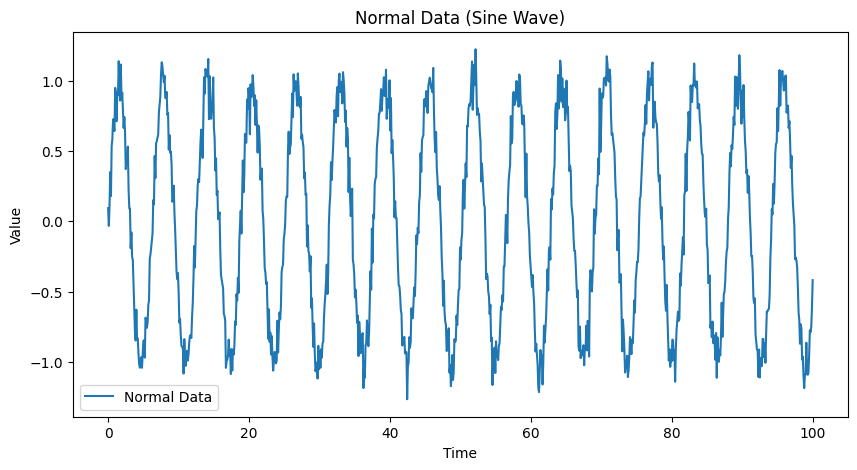

In [16]:
df.plot(x = 'Time', y = 'Normal Data', figsize=(10, 5))
plt.title("Normal Data (Sine Wave)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

In [17]:
# Introduce anomalies (random spikes)
anomaly_indices = np.random.choice(1000, 50, replace=False)
anomalies = normal_data.copy()
anomalies[anomaly_indices] += np.random.uniform(3, 5, size=50)


In [31]:
anomalies.shape

(1000,)

In [18]:
anomaly_indices

array([415,  36, 375, 399, 498,  40, 231, 679, 152, 639, 965, 304, 696,
       674, 169, 846, 298, 563, 936, 512, 707, 559,  85, 475,  30, 906,
        46, 573,  48, 848,  71, 640, 756, 346, 460, 829, 245, 716, 332,
       956, 637, 597,  59, 884, 622, 290, 665, 778, 617, 215])

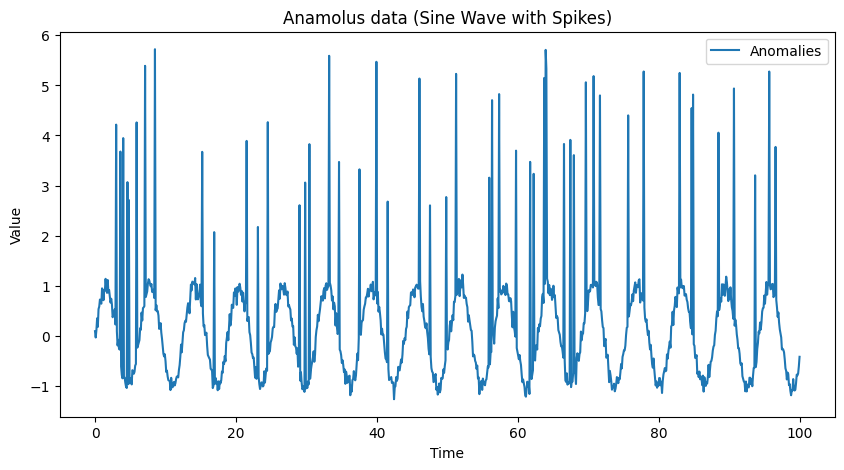

In [19]:
anomalies_df = pd.DataFrame({'Time': t, 'Anomalies': anomalies})
anomalies_df.plot(x = 'Time', y = 'Anomalies', figsize=(10, 5))
plt.title("Anamolus data (Sine Wave with Spikes)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

In [35]:
# Combine normal and anomaly data
data = np.concatenate([normal_data, anomalies]).reshape(-1, 1)

In [36]:
data.shape

(2000, 1)

In [37]:
data

array([[ 0.09372691],
       [-0.03258557],
       [ 0.11557616],
       ...,
       [-0.75108174],
       [-0.60974103],
       [-0.41848254]])

In [38]:
data_df = pd.DataFrame(data, columns=['Value'])

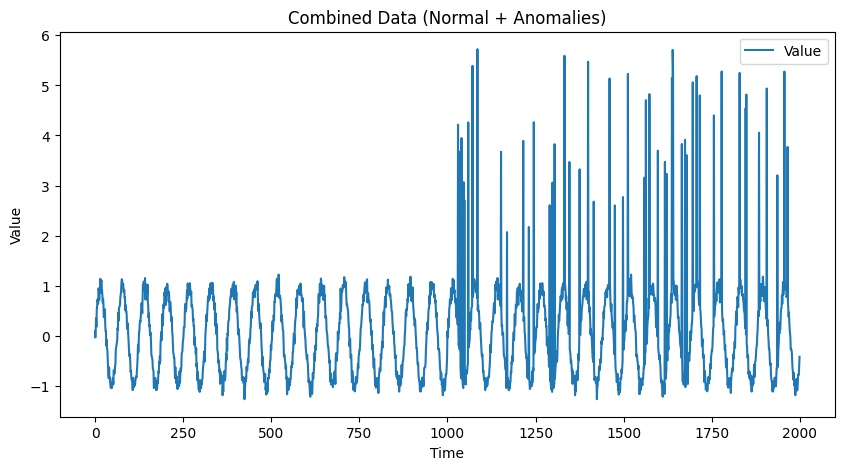

In [39]:
data_df.plot(figsize=(10, 5))
plt.title("Combined Data (Normal + Anomalies)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

In [40]:
# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [26]:
data_scaled.shape

(2000, 1)

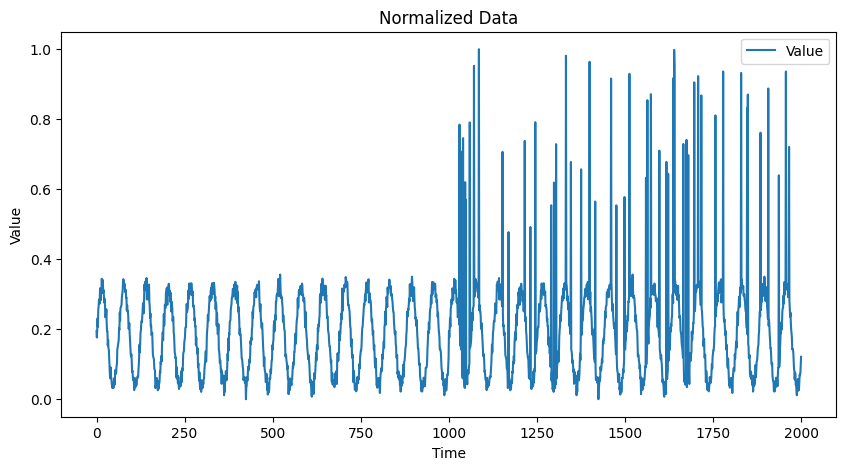

In [41]:
data_scaled_df = pd.DataFrame(data_scaled, columns=['Value'])
data_scaled_df.plot(figsize=(10, 5))
plt.title("Normalized Data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

In [42]:
# Split data into training (normal only) and testing (normal + anomalies)
X_train, X_test = train_test_split(data_scaled[:1000], test_size=0.2, random_state=42)
X_test = np.concatenate([X_test, data_scaled[1000:]])  # Add anomalies to test set


In [43]:
X_train.shape, X_test.shape

((800, 1), (1200, 1))

### Autoencoder model

In [45]:
# Define Autoencoder architecture
input_dim = X_train.shape[1]

autoencoder = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=(input_dim,)),
    layers.Dense(8, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(input_dim, activation='sigmoid')
])

# Compile model
autoencoder.compile(optimizer='adam', loss='mse')

# Train model on normal data
history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=16, validation_data=(X_test, X_test))


Epoch 1/50


/Users/harig/miniforge3/envs/anomaly/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1033 - val_loss: 0.0750
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0561 - val_loss: 0.0381
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0190 - val_loss: 0.0341
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0145 - val_loss: 0.0324
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0135 - val_loss: 0.0312
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0122 - val_loss: 0.0297
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0121 - val_loss: 0.0279
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0109 - val_loss: 0.0264
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0105 - val_loss: 0.0240
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0095 - val_loss: 0.0218
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0084 - val_loss: 0.0201
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0078 - val_loss: 0.0180


### Step 5: Detect Anomalies

In [46]:
autoencoder

<Sequential name=sequential, built=True>

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


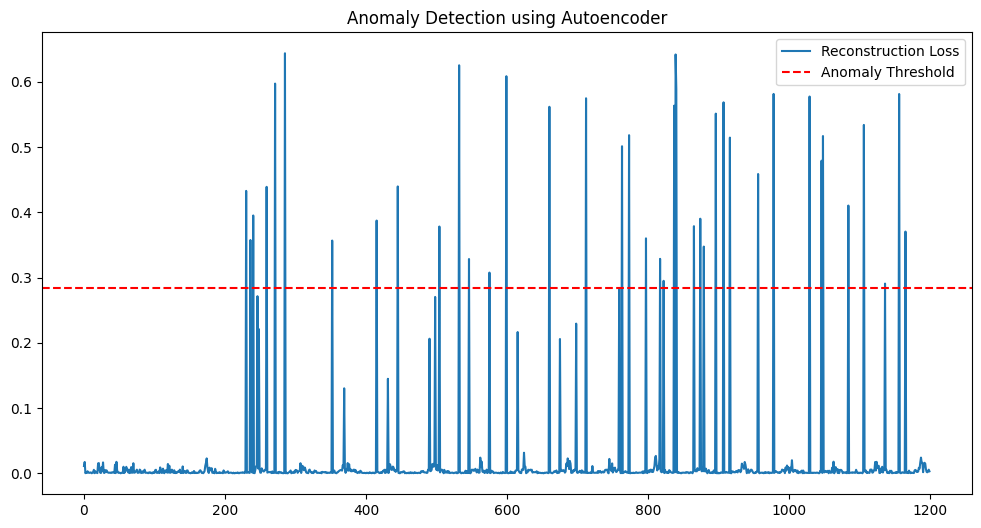

Total anomalies detected: 40


In [47]:
# Compute reconstruction loss (MSE)
X_test_pred = autoencoder.predict(X_test)
mse = np.mean(np.abs(X_test - X_test_pred), axis=1)

# Set threshold (mean + 3 * std)
threshold = np.mean(mse) + 3 * np.std(mse)

# Identify anomalies
anomalies = mse > threshold

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(mse, label="Reconstruction Loss")
plt.axhline(y=threshold, color='r', linestyle='--', label="Anomaly Threshold")
plt.legend()
plt.title("Anomaly Detection using Autoencoder")
plt.show()

# Print number of detected anomalies
print(f"Total anomalies detected: {np.sum(anomalies)}")


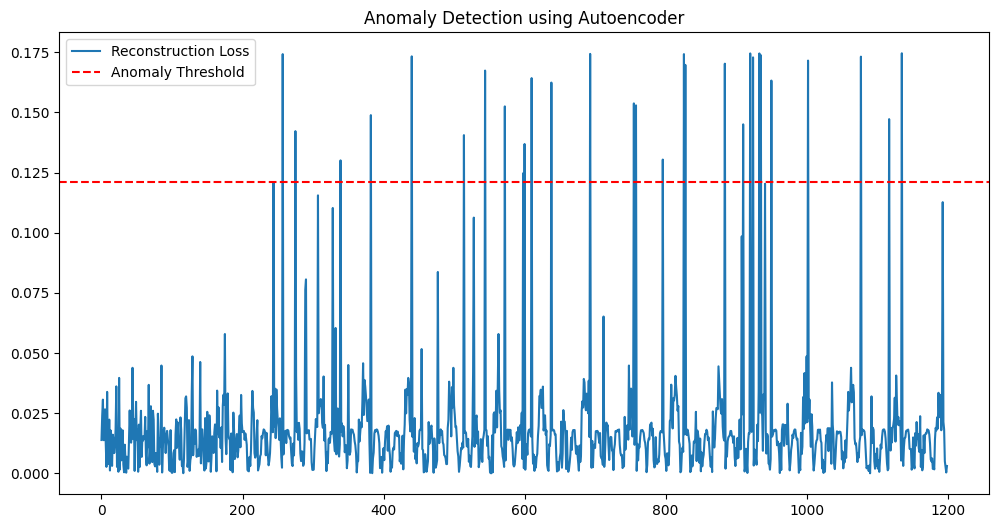

Total anomalies detected: 30


In [20]:
# Set threshold (mean + 3 * std)
threshold = np.mean(mse) + 4 * np.std(mse)

# Identify anomalies
anomalies = mse > threshold

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(mse, label="Reconstruction Loss")
plt.axhline(y=threshold, color='r', linestyle='--', label="Anomaly Threshold")
plt.legend()
plt.title("Anomaly Detection using Autoencoder")
plt.show()

# Print number of detected anomalies
print(f"Total anomalies detected: {np.sum(anomalies)}")